### Imports

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy.stats as stats
from sklearn.metrics import pairwise_distances, silhouette_score, davies_bouldin_score

# 1. Prepare Time Series Dataset

In [2]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 77)


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,729.0,2015.0,Indianapolis,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1459.0,2017.0,Kane,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1404.0,2016.0,Detroit,42.4190,-83.0393,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1383.0,2016.0,Washington,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,894.0,2015.0,Pittsburgh,40.4621,-80.0308,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


## 1.1 Select cities

In [3]:
dataset['year'].value_counts()

year
2017.0    61389
2016.0    58724
2015.0    53335
2014.0    51684
2018.0    13801
2013.0      448
Name: count, dtype: int64

Keep only incidents regarding [2014, 2015, 2016, 2017], as by project assignment instructions.

In [4]:
dataset = dataset[(dataset['year'] > 2013) & (dataset['year'] < 2018)]

Analysis of cities reveals that many cities are present with different names, resulting in incorrect city value counts.

In [5]:
with open('debugging/cities.txt', 'w') as f:
    for item in dataset['city_or_county'].unique():
        f.write("%s\n" % item)
        
# Write city and value counts of each city to a file
with open('debugging/city_counts.txt', 'w') as f:
    f.write(dataset['city_or_county'].value_counts().to_string())

print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))
        

There are 12596 unique cities in the dataset


Eliminate parenthesis with county or extra information.

In [6]:
# Eliminate all data between parenthesis in the city column using re module
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: re.sub(r"\(.*\)", "", x))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 11762 unique cities in the dataset


Sort cities alphabetically to see if there are still duplicates and how relevant they are.

In [7]:
# Get all cities and sort them alphabetically and write them in a file
cities = dataset['city_or_county'].unique()
cities.sort()
with open('debugging/cities2.txt', 'w') as f:
    for item in cities:
        f.write("%s\n" % item)

We can see that there are many cities which differ in having a space in the end, let's remove all spaces to avoid problems.

In [8]:
# Remove all spaces from city names
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: x.replace(" ", ""))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10416 unique cities in the dataset


In [9]:
dataset['city_or_county'] = dataset['city_or_county'].str.upper()
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10331 unique cities in the dataset


Introducing a week parameter and filtering only cities with a number of weeks with incidents greater than 15% of the total number of the weeks of the 4 years.

In [10]:
dataset['week'] = " "

# Date attribute is a progressive integer number, starting from 0
# Assign a week number to each date
dataset['date'] = dataset['date'] - dataset['date'].min()
dataset['week'] = dataset['date'].apply(lambda x: int(x / 7))

n_weeks = dataset['week'].max()
n_weeks

208

In [11]:
cities = dataset['city_or_county'].unique()
dropping_threshold = 0.15

for city in cities:
    city_data = dataset[dataset['city_or_county'] == city]
    city_weeks_with_incidents = city_data['week'].nunique()

    # Drop the city if it has less than 15% of the weeks with incidents
    if city_weeks_with_incidents < n_weeks * dropping_threshold:
        dataset = dataset[dataset['city_or_county'] != city]

print('Number of cities for which time series will be generated:', dataset['city_or_county'].nunique())
dataset.head()

Number of cities for which time series will be generated: 713


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y,week
0,364.0,2015.0,INDIANAPOLIS,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,5.000000e-01,-8.660254e-01,52
2,1039.0,2016.0,DETROIT,42.4190,-83.0393,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,-5.000000e-01,8.660254e-01,148
3,1018.0,2016.0,WASHINGTON,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,-8.660254e-01,5.000000e-01,145
4,529.0,2015.0,PITTSBURGH,40.4621,-80.0308,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,1.224647e-16,-1.000000e+00,75
7,805.0,2016.0,NEWHAVEN,41.2945,-72.9457,20.0,20.0,20.0,1.0,0.0,...,False,False,False,False,False,False,False,1.000000e+00,6.123234e-17,115


In [12]:
# Save dataset in csv
dataset.to_csv('debugging/ts.csv', index=False)

## 1.3 Generation with different score functions for each subtask

In [13]:
from tslearn.preprocessing import (TimeSeriesScalerMeanVariance,
                                   TimeSeriesScalerMinMax)

Define the functions to compute the score for each of the two subtasks

In [14]:
# Define the threshold for the number of killed people in a city 
# to be considered as a label 1 class
ISKILLED_THRESHOLD = 10

def compute_week_score(week_data, task):
    # Compute the score for a given week, to be used in the time series
    if task == 'task1':
        score = (week_data['killed_ratio'] * week_data['n_participants']).sum()
    elif task == 'shapelet_learning':
        score = (week_data['killed_ratio'] * week_data['n_participants']).sum()
    return score

def generate_time_series(city_data, n_weeks, task):
    """Generate the time series for a given city

    Args:
        city_data (pandas.DataFrame): Data for a given city
        n_weeks (int): Number of weeks in the dataset
        task (str): Task to be performed

    Returns:
        numpy.ndarray: Time series for the given city
            Shape (n_weeks, ) if task is 'task1'    
            Shape (n_weeks, 2) if task is 'shapelet_learning'
    """
    # Generate the time series for a given city
    time_series = np.zeros(n_weeks)
    for week in range(n_weeks):
        week_data = city_data[city_data['week'] == week]
        if week_data.shape[0] > 0:
            time_series[week] = compute_week_score(week_data, task)

    return time_series

def generate_time_series_with_label(city_data, n_weeks, task):
    """Generate the time series for a given city.
    Label is referred to the whole time series.

    Args:
        city_data (pandas.DataFrame): Data for a given city
        n_weeks (int): Number of weeks in the dataset
        task (str): Task to be performed

    Returns:
        numpy.ndarray: Time series for the given city
            Shape (n_weeks, )
        int: Label for the time series
    """
    # Generate the time series for a given city
    time_series = np.zeros(n_weeks)
    for week in range(n_weeks):
        week_data = city_data[city_data['week'] == week]
        if week_data.shape[0] > 0:
            time_series[week] = compute_week_score(week_data, 'shapelet_learning')
    
    if (city_data['killed_ratio'] * city_data['n_participants']).sum() > ISKILLED_THRESHOLD:
        label = 1
    else:
        label = 0

    return time_series, label

def generate_time_series_dataset(dataset, task):
    """Generate the time series dataset

    Args:
        dataset (pandas.DataFrame): Dataset
        task (str): Task to be performed

    Returns:
        if task is 'task1':
            numpy.ndarray: Time series dataset
        elif task is 'shapelet_learning':
            list: [Time series dataset, labels]
        
        numpy.ndarray: Cities of the time series dataset
    """
    # Generate the time series for all cities
    n_weeks = dataset['week'].max()
    cities = dataset['city_or_county'].unique()
    time_series = []
    labels = []
    for city in cities:
        city_data = dataset[dataset['city_or_county'] == city]

        if task == 'shapelet_learning':
            ts, label = generate_time_series_with_label(city_data, n_weeks, task)
            time_series.append(ts)
            labels.append(label)
        else:
            time_series.append(generate_time_series(city_data, n_weeks, task))
        
    time_series = np.array(time_series)
    labels = np.array(labels)

    if task == 'shapelet_learning':
        # Add the labels to the time series, adjusting the shape of labels 
        time_series = [time_series, labels]

    return time_series, cities

class TSScaler:
    """Base class to scale time series data
    """
    def __init__(self, verbose = True):
        self.verbose = verbose

    def fit_transform(self, time_series):
        """Fit and transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        return NotImplementedError

    def transform(self, time_series):
        """Transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        return NotImplementedError
    
    def inverse_transform(self, time_series):
        """Inverse transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        return NotImplementedError
    

class MinMaxScaler(TSScaler):
    """Class to scale time series data using minmax scaling
    """
    def __init__(self, verbose = True):
        super().__init__(verbose)
        self.min = None
        self.max = None

    def fit_transform(self, time_series):
        """Fit and transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        self.min = time_series.min(axis = 1).min(axis = 0)
        self.max = time_series.max(axis = 1).max(axis = 0)
        return self.transform(time_series)

    def transform(self, time_series):
        """Transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        if self.min is None or self.max is None:
            raise ValueError('MinMaxScaler is not fitted')

        if self.verbose:
            print('Scaling time series with MinMaxScaler')
        return (time_series - self.min) / (self.max - self.min)

    def inverse_transform(self, time_series):
        """Inverse transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        if self.min is None or self.max is None:
            raise ValueError('MinMaxScaler is not fitted')

        if self.verbose:
            print('Inverse scaling time series with MinMaxScaler')
        return time_series * (self.max - self.min) + self.min

In our case, no resampling is necessary as all sequences are of same length, as we define them over 208 weeks. Furthermore, no approximation is needed as the resulting dataset of time series is small.

<b>Important!!!</b> Keep in mind that minmax scaler in tslearn scales each time series independently, so the two following time series of killed people in our dataset will look identical:

1. 0 - 0 - 100 - 0 - ... - 0
2. 0 - 0 -  1  - 0 - ... - 0

This is because usually one would like to do amplitude scaling on the dataset (e.g. if the signal is electrical tension, and the important thing is the shape of the signal and not the amplitude itself). However, in our case it is important to consider this loss in information. For this reason, we implement our own minmax scaler.

# 2. Clustering

## 2.1 Generate time series

In [16]:
ts_dataset, cities = generate_time_series_dataset(dataset, task = 'task1')
ts_dataset.shape

(713, 208)

In [23]:
scaler_minmax = MinMaxScaler()
scaler_zscore = TimeSeriesScalerMeanVariance()  
scaler_minmax_independent = TimeSeriesScalerMinMax()

ts_dataset_minmax = scaler_minmax.fit_transform(ts_dataset)
ts_dataset_zscore = scaler_zscore.fit_transform(ts_dataset)
ts_dataset_minmax_independent = scaler_minmax_independent.fit_transform(ts_dataset)

print('Minmax scaled dataset shape:', ts_dataset_minmax.shape)
print('Zscore scaled dataset shape:', ts_dataset_zscore.shape)
print('Minmax independent scaled dataset shape:', ts_dataset_minmax_independent.shape)
print()
print('Shapes of minmax scaled dataset modified for compatibility with tslearn:')
ts_dataset_minmax = np.expand_dims(ts_dataset_minmax, axis=2)
print('Minmax scaled dataset shape:', ts_dataset_minmax.shape)



Scaling time series with MinMaxScaler
Minmax scaled dataset shape: (713, 208)
Zscore scaled dataset shape: (713, 208, 1)
Minmax independent scaled dataset shape: (713, 208, 1)

Shapes of minmax scaled dataset modified for compatibility with tslearn:
Minmax scaled dataset shape: (713, 208, 1)


We'll use the minmax scaled dataset as we defined it with our class.

In [24]:
scaler = scaler_minmax
X = ts_dataset_minmax

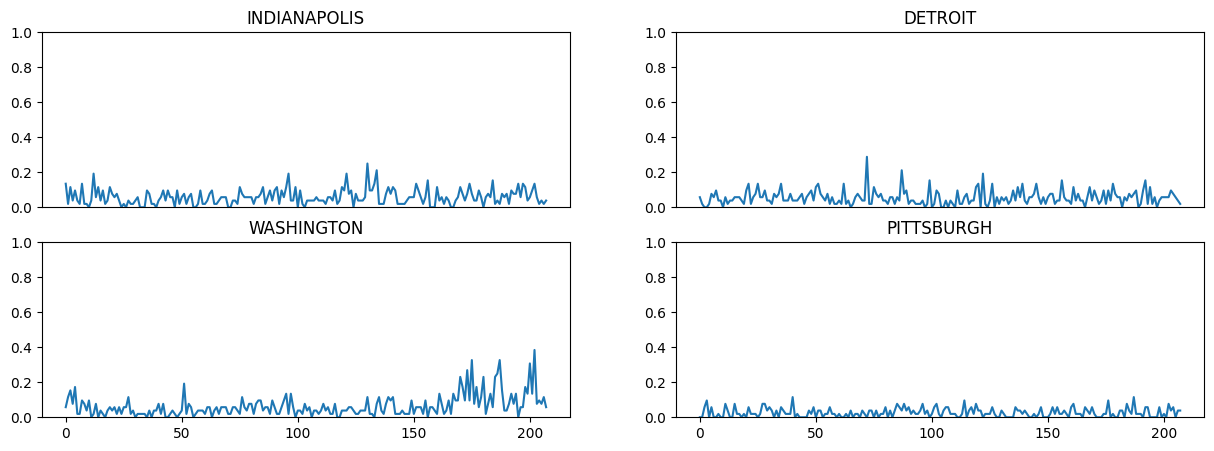

In [25]:
plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(X[i])
    plt.ylim(0, 1)
    if i < 2:
        plt.xticks([])
    plt.title(cities[i])
plt.show()

## 2.2 Shape-based Clustering 

In [26]:
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.clustering import silhouette_score as ts_silhouette_score

### 2.2.1 KMeans with Euclidean Distance

In [27]:
max_k = 20

sse_list_km = []
silhouette_list_km = []

for k in range(2, max_k + 1):
    
    time_init = time.time()

    km = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=100, random_state=0, n_init=10)
    km.fit(X)

    if km._iter == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km.append(km.inertia_)
    silhouette_list_km.append(ts_silhouette_score(X, km.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

Finished clustering for k = 2; time elapsed: 4.370 s
Finished clustering for k = 3; time elapsed: 6.030 s
Finished clustering for k = 4; time elapsed: 8.420 s
Finished clustering for k = 5; time elapsed: 10.758 s
Finished clustering for k = 6; time elapsed: 7.651 s
Finished clustering for k = 7; time elapsed: 9.206 s
Finished clustering for k = 8; time elapsed: 7.715 s
Finished clustering for k = 9; time elapsed: 8.418 s
Finished clustering for k = 10; time elapsed: 7.007 s
Finished clustering for k = 11; time elapsed: 7.693 s
Finished clustering for k = 12; time elapsed: 7.584 s
Finished clustering for k = 13; time elapsed: 7.356 s
Finished clustering for k = 14; time elapsed: 7.687 s
Finished clustering for k = 15; time elapsed: 7.465 s
Finished clustering for k = 16; time elapsed: 7.857 s
Finished clustering for k = 17; time elapsed: 8.077 s
Finished clustering for k = 18; time elapsed: 6.700 s
Finished clustering for k = 19; time elapsed: 7.000 s
Finished clustering for k = 20; tim

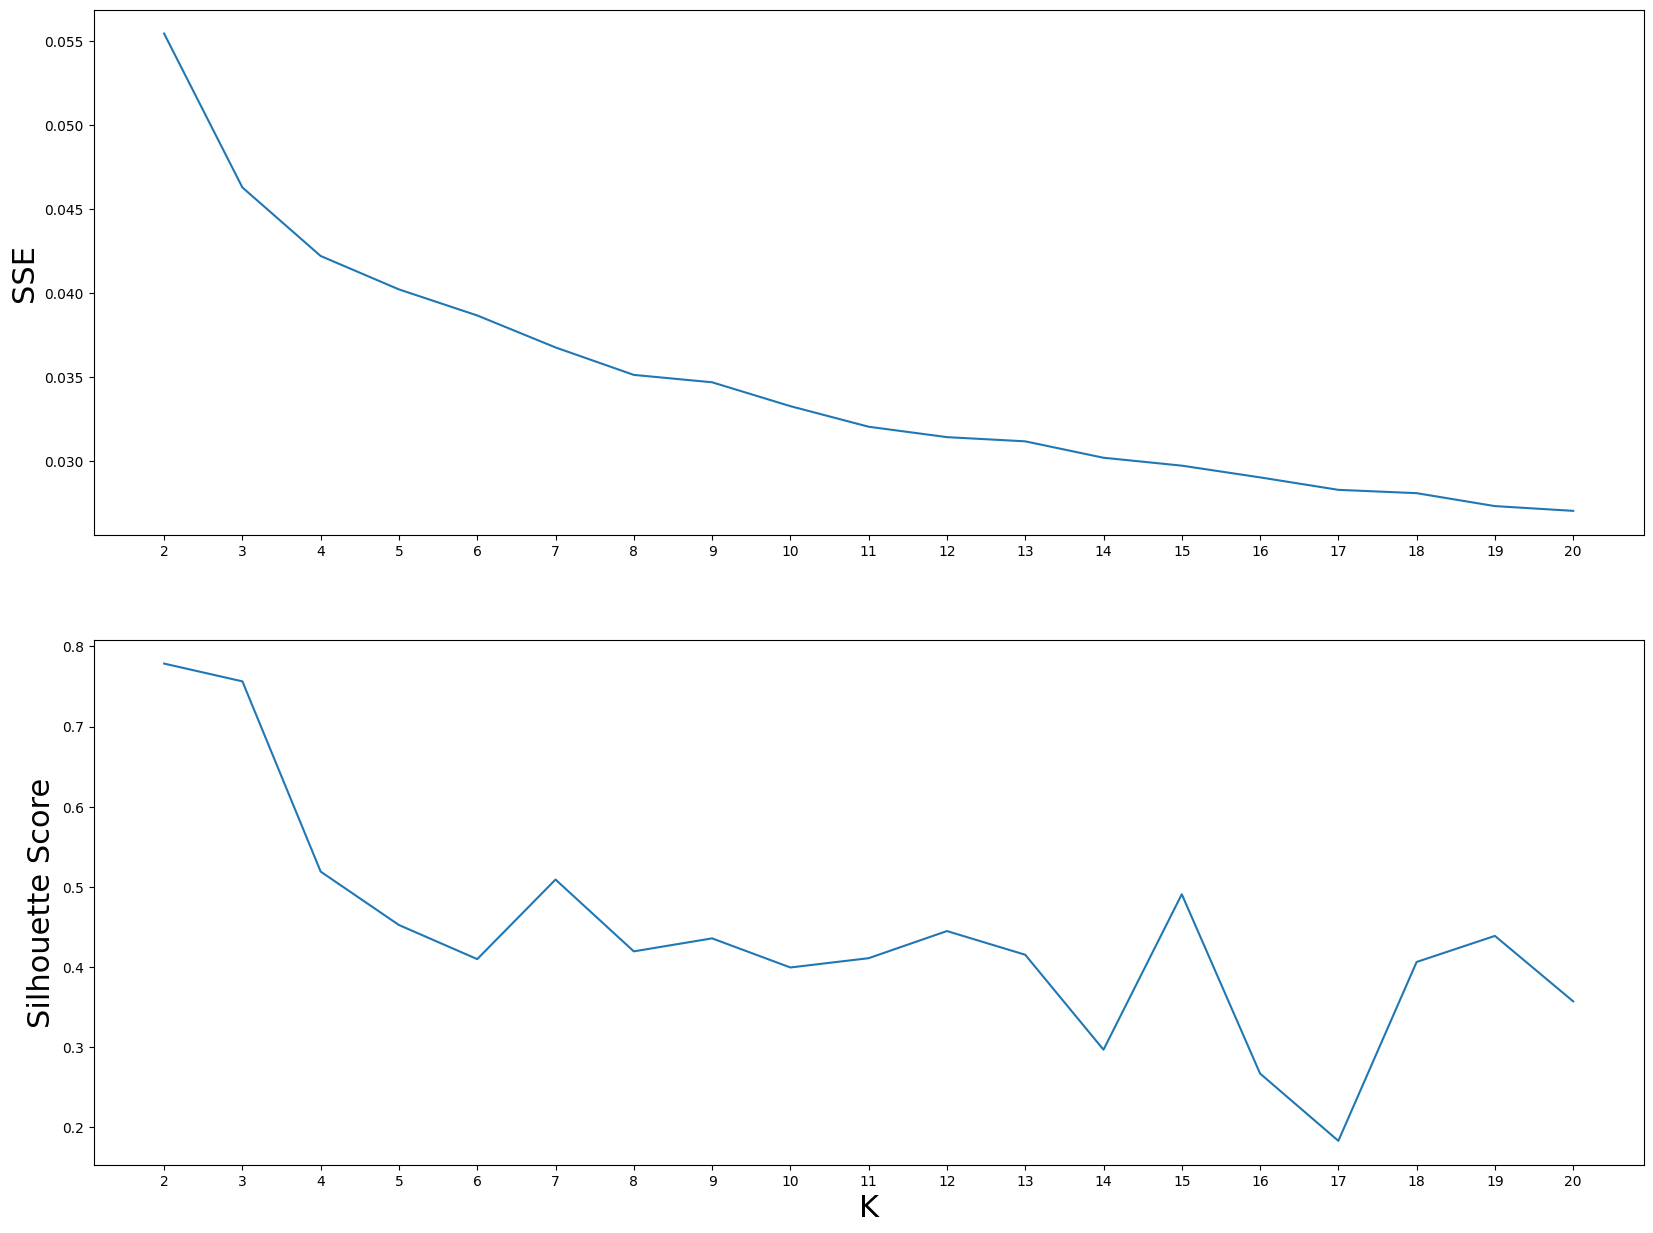

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km) + 2), sse_list_km)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km) + 2))

ax[1].plot(range(2, len(silhouette_list_km) + 2),silhouette_list_km)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km) + 2))


plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [29]:
CHOSEN_K = 3

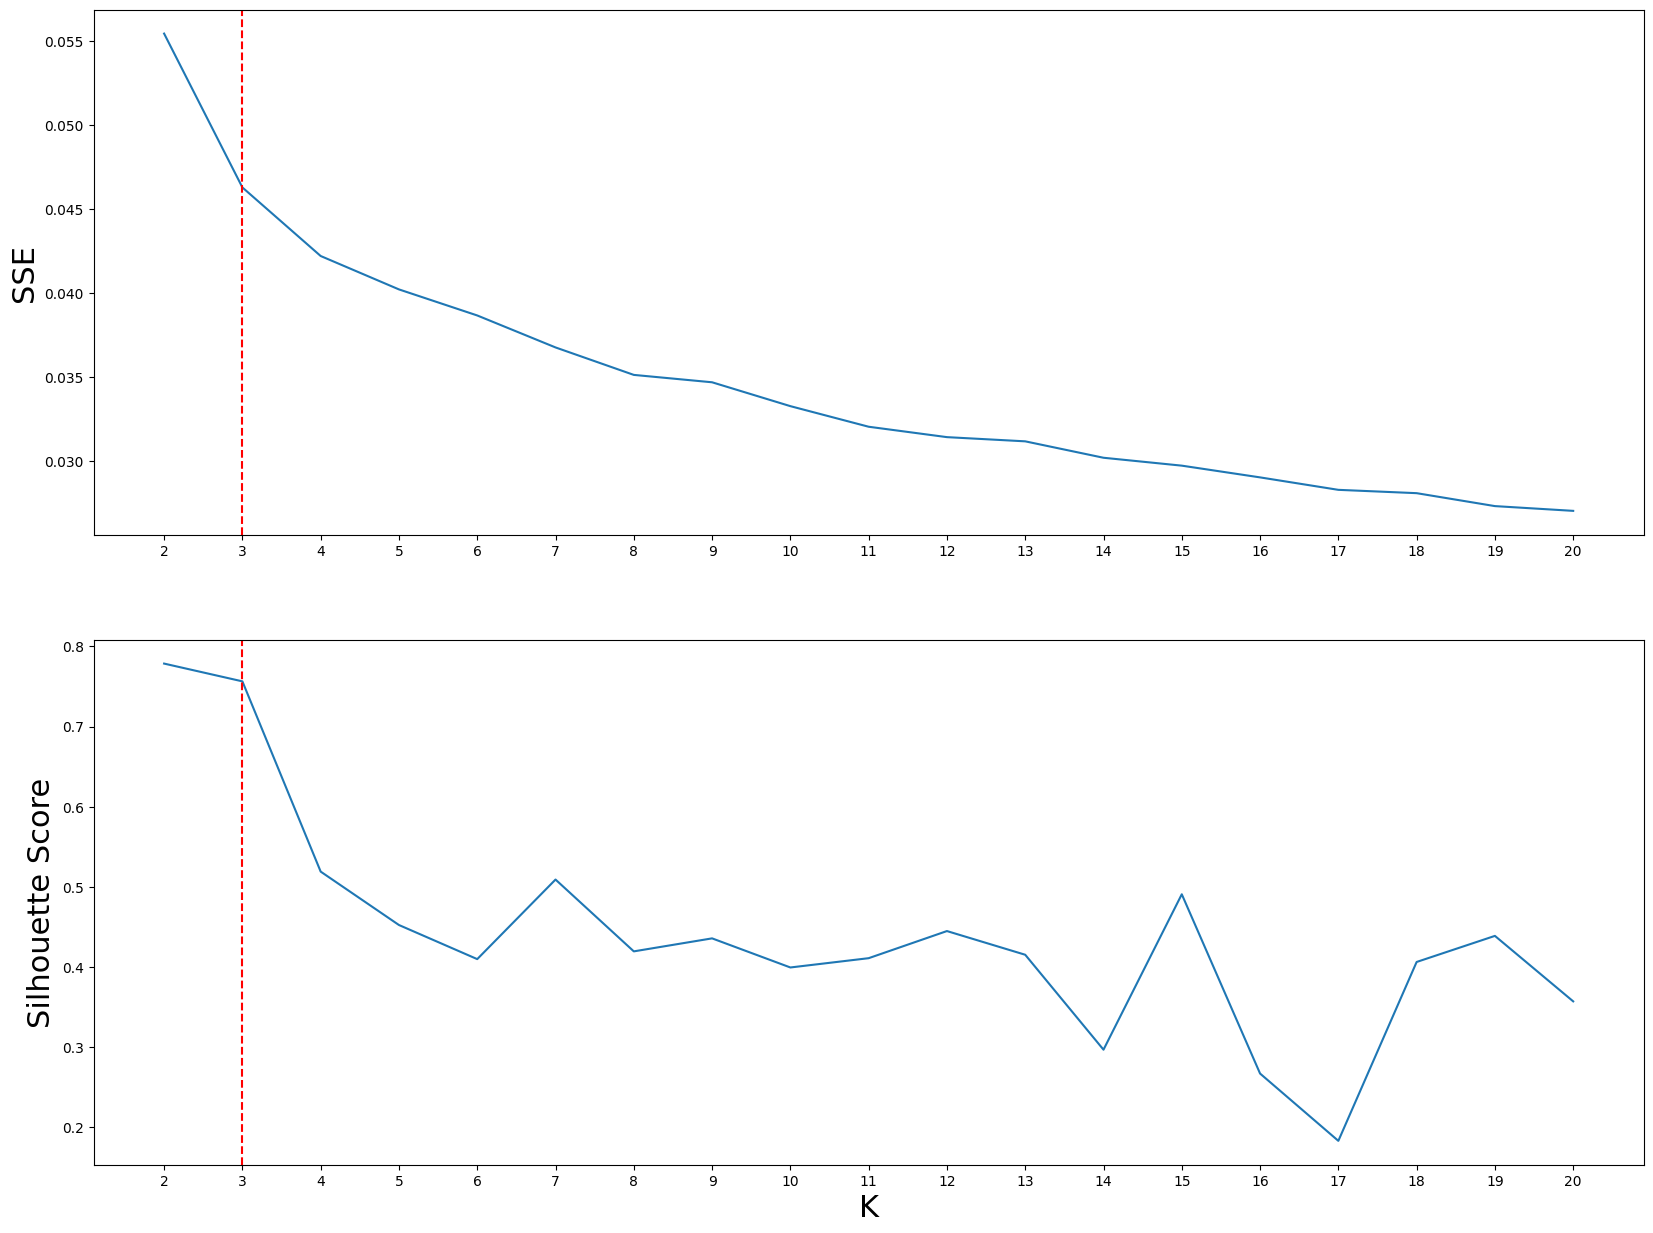

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km) + 2), sse_list_km)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km) + 2))

ax[1].plot(range(2, len(silhouette_list_km) + 2), silhouette_list_km)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [31]:
n_clusters = CHOSEN_K
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=1000, random_state=0, n_init=10)
km.fit(X)

TimeSeriesKMeans(max_iter=1000, n_init=10, random_state=0)

In [33]:
km_centers = scaler.inverse_transform(km.cluster_centers_)

Inverse scaling time series with MinMaxScaler


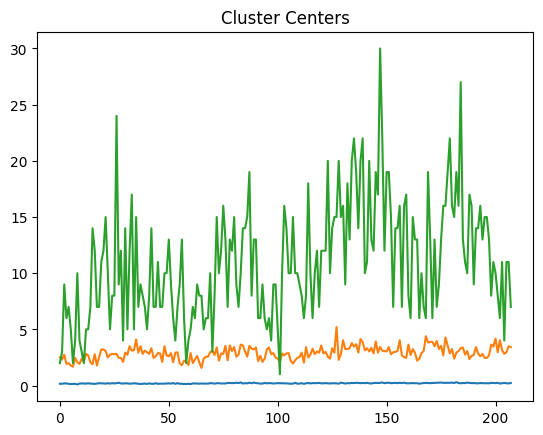

In [34]:
plt.plot(km_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

### 2.2.1 KMeans with DTW

DTW metric requires long computations, as it has complexity asymptotically different from Euclidean distance. Let's explore how much the cost rises.

In [ ]:
n_clusters = 3

In [ ]:
time_init = time.time()
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, n_init=10)
km_dtw.fit(X)
checkpoint = time.time()
print("Time elapsed for DTW clustering: %.3f s" % (time.time() - time_init))
silhouette_km_dtw = ts_silhouette_score(X, km_dtw.labels_, metric="dtw")
print("Time elapsed for DTW silhouette score: %.3f s" % (time.time() - checkpoint))
print("Number of iterations during training: %d" % km_dtw.n_iter_)
print("Total time elapsed for DTW clustering and silhouette score: %.3f s" % (time.time() - time_init))


This algorithm is much slower than the Euclidean metric version. This is to be expected, as computing Euclidean distance is linear complexity in time, whilst DTW isn't.
 
<b>Let's try with some constraints on DTW!</b>

In [ ]:
time_init = time.time()
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
km_dtw.fit(X)
checkpoint = time.time()
print("Time elapsed for constrained DTW clustering: %.3f s" % (time.time() - time_init))
silhouette_km_dtw = ts_silhouette_score(X, km_dtw.labels_, metric="dtw")
print("Time elapsed for DTW silhouette score: %.3f s" % (time.time() - checkpoint))
print("Number of iterations during training: %d" % km_dtw.n_iter_)
print("Total time elapsed for DTW clustering and silhouette score: %.3f s" % (time.time() - time_init))

We notice that even though constraining dtw helps a lot, actually the most expensive part is calculating the silhouette score with dtw. So let's use euclidean distance as a metric in silhouette score even when using dtw for clustering. It is still a valid choice for evaluating the clustering.

In [ ]:
time_init = time.time()
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
km_dtw.fit(X)
checkpoint = time.time()
print("Time elapsed for constrained DTW clustering: %.3f s" % (time.time() - time_init))
silhouette_km_dtw = ts_silhouette_score(X, km_dtw.labels_, metric="euclidean")
print("Time elapsed for Euclidean silhouette score: %.3f s" % (time.time() - checkpoint))
print("Number of iterations during training: %d" % km_dtw.n_iter_)
print("Total time elapsed for DTW clustering and silhouette score: %.3f s" % (time.time() - time_init))

Now that we have brought down the time complexity, let's actually run the search for k. Keep max_k = 10 to avoid computing for too long.

In [ ]:
max_k = 10 

sse_list_km_dtw = []
silhouette_list_km_dtw = []

for k in range(2, max_k + 1):   
    time_init = time.time()

    km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
    km_dtw.fit(X)

    if km_dtw._iter == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_dtw.append(km_dtw.inertia_)        
    silhouette_list_km_dtw.append(ts_silhouette_score(X, km_dtw.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_dtw) + 2), sse_list_km_dtw)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_dtw) + 2))

ax[1].plot(range(2, len(silhouette_list_km_dtw) + 2), silhouette_list_km_dtw)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_dtw) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [ ]:
CHOSEN_K = 3

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_dtw) + 2), sse_list_km_dtw)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_dtw) + 2))

ax[1].plot(range(2, len(silhouette_list_km_dtw) + 2), silhouette_list_km_dtw)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_dtw) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [ ]:
n_clusters = CHOSEN_K
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
km_dtw.fit(X)

In [ ]:
km_dtw_centers = scaler.inverse_transform(km_dtw.cluster_centers_)

Inverse scaling time series with MinMaxScaler


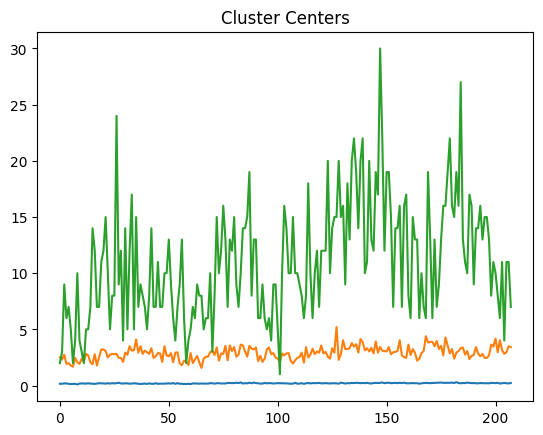

In [ ]:
plt.plot(km_dtw_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

### 2.2.1 KShape

In [ ]:
max_k = 20

sse_list_ks = []
silhouette_list_ks = []

for k in range(2, max_k + 1):
    
    time_init = time.time()
    ks = KShape(n_clusters=k, max_iter=100, random_state=0, n_init=10)
    ks.fit(X)

    if ks._iter == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_ks.append(ks.inertia_)
    silhouette_list_ks.append(ts_silhouette_score(X, ks.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_ks) + 2), sse_list_ks)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_ks) + 2))

ax[1].plot(range(2, len(silhouette_list_ks) + 2), silhouette_list_ks)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_ks) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [ ]:
CHOSEN_K = 2

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_ks) + 2), sse_list_ks)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_ks) + 2))

ax[1].plot(range(2, len(silhouette_list_ks) + 2), silhouette_list_ks)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_ks) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [ ]:
n_clusters = CHOSEN_K   
ks = KShape(n_clusters=n_clusters, max_iter=1000, random_state=0)
ks.fit(X)

In [ ]:
ks_centers = scaler.inverse_transform(ks.cluster_centers_)

Inverse scaling time series with MinMaxScaler


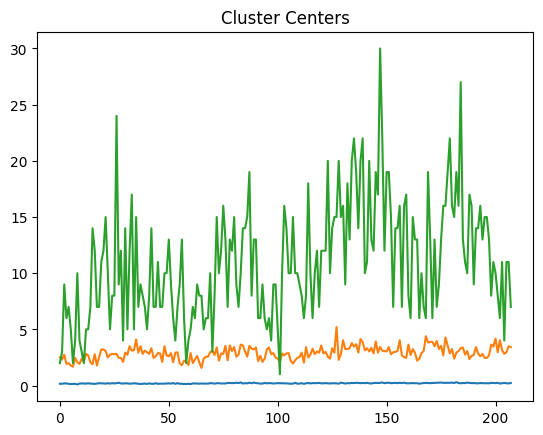

In [ ]:
plt.plot(ks_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

In [ ]:
# Inertia of the three algorithms
print("Inertia of the three algorithms:")
print("Euclidean k-means:", km.inertia_)
print("DTW k-means:", km_dtw.inertia_)
print("k-Shape:", ks.inertia_)

## 2.3 Feature-based Clustering

In [ ]:
from sklearn.cluster import DBSCAN, KMeans

In [ ]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [ ]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [ ]:
# repeat code for kmeans, only using features as metric
sse_list_km_features = []
silhouette_list_km_features = []

for k in range(2, max_k + 1):   
    time_init = time.time()

    km_features = KMeans(n_clusters=k, max_iter=100, random_state=0, n_init=10)
    km_features.fit(X)

    if km_features._iter == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_features.append(km_features.inertia_)        
    silhouette_list_km_features.append(ts_silhouette_score(X, km_features.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_features) + 2), sse_list_km_features)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_features) + 2))

ax[1].plot(range(2, len(silhouette_list_km_features) + 2), silhouette_list_km_features)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_features) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [ ]:
CHOSEN_K = 3

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_features) + 2), sse_list_km_features)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_features) + 2))

ax[1].plot(range(2, len(silhouette_list_km_features) + 2), silhouette_list_km_features)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_features) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [ ]:
n_clusters = CHOSEN_K
km_features = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0, n_init=10)
km_features.fit(X)

In [ ]:
plt.plot(km_features.cluster_centers_.reshape(n_clusters, X.shape[1]).T)
plt.show()

In [ ]:
print("Inertia of k-means with extracted features:", km_features.inertia_)

## 2.4 Compression-based clustering

In [ ]:
import zlib

In [ ]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [ ]:
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

In [ ]:
dbscan = DBSCAN(eps=0.965, min_samples=5, metric='precomputed')
dbscan.fit(M)

## 2.5 Approximation-based clustering

In [ ]:
from tslearn.piecewise import PiecewiseAggregateApproximation

In [ ]:
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)

In [ ]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [ ]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_paa)

In [ ]:
plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 3))
plt.show()

Recompute the centroid from time series in cluster.

In [ ]:
for i in range(3):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()

# 3. Motif Extraction

In [ ]:
import stumpy

In [ ]:
# Stumpy library calculates the matrix profile for a given time series
# Select the city with most weeks with incidents in the dataset and calculate its matrix profile
non_zero_values = np.count_nonzero(X, axis=1)
city_index = np.argmax(non_zero_values)
city = cities[city_index]

ts = X[city_index]  
print('City with most weeks with incidents:', city)
print('Number of weeks with incidents:', non_zero_values[city_index])
ts = ts.reshape(ts.shape[0])
ts.shape

In [ ]:
# Plot the time series

plt.plot(ts)

In [ ]:
w = 10
mp = stumpy.stump(ts, w)[:, 0]

plt.plot(mp)
plt.show()

In [ ]:
# Find the motifs and their locations
motif_dist, motif_idx = stumpy.motifs(ts, mp, max_motifs=5)

In [ ]:
plt.plot(ts)

colors = ['r', 'g', 'k', 'b', 'y'][:len(motif_dist)]

for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)

plt.show()

In [ ]:
for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)
    plt.show()

# 4. Anomaly Detection

Calculate anomalies as out of distribution values of the matrix profile.

In [ ]:
# Calculate z-scores for the matrix profile
z_scores = stats.zscore(mp.tolist())

# Define a threshold (e.g., 3 standard deviations)
threshold = 3

# Find anomalies based on the threshold
anomalies = np.where(np.abs(z_scores) > threshold)[0]

In [ ]:
plt.plot(ts)
for a in anomalies:
    a_shape = ts[a:a+w]
    plt.plot(range(a, a+w), a_shape, color='r', lw=3)

plt.show()

# 5. Shapelet Extraction

In [ ]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split
import tensorflow as tf

## 5.1 Dataset preparation with labelling

In [ ]:
ts_dataset, cities = generate_time_series_dataset(dataset, task = 'shapelet_learning', scaling = 'minmax')

X = ts_dataset[0]
y = ts_dataset[1]


In [ ]:
# See how many time series in dataset have at least one killing and how many don't
# This is the label for the shapelet learning task
print('Number of time series with at least one killing:', np.sum(y))
print('Number of time series with no killings:', y.shape[0] - np.sum(y))

In [ ]:
# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

## 5.2 Shapelet Discovery

Define the hyperparameters.

In [ ]:
# Define hyperparams
n_ts, ts_sz = X_train.shape[:2]
l = 0.05
r = 4

In [ ]:
# Follow github repo https://github.com/stephanielees/shapeletsLTS-humansensor/blob/main/shapelet-tslearn.ipynb
PERCENTAGE = 0.1
# Select randomly 10% of the time series in the training set to extract shapelets from
indexes = np.random.choice(X_train.shape[0], int(X_train.shape[0] * PERCENTAGE), replace=False)
X_train_small = X_train[indexes]
y_train_small = y_train[indexes]

In [ ]:
shapelet_dict = grabocka_params_to_shapelet_size_dict(n_ts = n_ts, ts_sz = ts_sz, n_classes = 2, l = l, r = r)
shapelet_dict

Generate shapelets on the small training set and then use those shapelets for doing the shapelet transform on all setes: the full training set, the validation set and the test set. We will then use these resulting shapelet-transformed sets to train the classifier.

In [ ]:
trans = LearningShapelets(weight_regularizer=0.001, batch_size=512, max_iter=2500, total_lengths=5,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), scale=False)

# Fit the model
trans.fit(X_train_small, y_train_small)
shapelets_learned = trans.shapelets_
shapelets_learned_as_ts = trans.shapelets_as_time_series

train_shapelets = trans.transform(X_train)
valid_shapelets = trans.transform(X_val)
test_shapelets = trans.transform(X_test)

print(train_shapelets.shape)
print(valid_shapelets.shape)
print(test_shapelets.shape)
print('Number of shapelets according to the shapelet dictionary:', sum(shapelet_dict.values()))
print('Actual number of shapelets learned:', shapelets_learned.shape[0])


In [ ]:
# Show the shapelets that are as many as we calculated in the dictionary
for shapelet_len, n_shapelets in shapelet_dict.items():  
    plt.figure(figsize=(8,5))
    for j in range(n_shapelets):
        plt.plot(shapelets_learned_as_ts[shapelet_len][j], label='Shapelet length {}'.format(shapelet_len))
    plt.legend()
    plt.show()

As explained in the paper, multiple similar shapelets is not necessarily a bad thing. In ML, generally, having two similar features might cause multicollinearity and bias, but in the case of shapelets, one shapelet might not be able to separate the data, so multiple similar shapelets may be actually useful.

Paper: https://www.ismll.uni-hildesheim.de/pub/pdfs/grabocka2014e-kdd.pdf

## 5.3 Classification with Shapelets

In [ ]:
import lightgbm as lgbm

In [ ]:
model = lgbm.LGBMClassifier(n_estimators = 3500, random_state=8)
model.fit(train_shapelets, y_train, eval_set=[(valid_shapelets, y_val)], eval_metric='accuracy')

### 5.3.1 Model evaluation

In [ ]:
# Evaluate the accuracy of the model on the test set
y_pred = model.predict(test_shapelets)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print('Accuracy on the test set:', accuracy)